# Homework 6: RNNs to Classify City names to Countries

In this project, we will be building a character-level recurrent neural network to classify city names to countries.

## Setup: Dataset / Packages

In [ ]:
#Import Packages
from os.path import exists
from sklearn.metrics import accuracy_score
import codecs
import math
import random
import string
import time
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
#Download and unzip files
!gdown 1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK # https://drive.google.com/file/d/1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK/view?usp=sharing
!gdown 1MptWweHF0JCNORroZUbqnEgboGO9vUG7 # https://drive.google.com/file/d/1MptWweHF0JCNORroZUbqnEgboGO9vUG7/view?usp=sharing
!gdown 1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo # https://drive.google.com/file/d/1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!gdown 1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw # https://drive.google.com/file/d/1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw/view?usp=sharing
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip
!unzip cities_train.zip

Downloading...
From: https://drive.google.com/uc?id=1gnDQ6sqtLAGZx0qcjj4f4kdz76-m2WvK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 17.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MptWweHF0JCNORroZUbqnEgboGO9vUG7
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 17.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hXANRbz9ov_w6nPYZK6r5IHj0I-l-Dlo
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 87.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.56MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw
To: /content/shakespeare_input.txt
100% 4.57M/4.57M [00:00<00:00, 49.8MB/s]
--2023-10-18 13:08:20--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguisti

In [ ]:
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    X = np.array(words)
    y = np.array(labels)
    return X, y

def getWords(baseDir, lang, train = True):
    suff = "train/" if train else "val/"
    arr = []
    with codecs.open(baseDir+suff+lang+".txt", "r",encoding='utf-8', errors='ignore') as fp:
        for line in fp:
            arr.append(line.rstrip("\n"))
    return np.array(arr)

def readData(baseDir, train=True):
    X, y = np.array([]), np.array([])
    for lang in languages:
        tempX = getWords(baseDir, lang, train)
        X = np.append(X, tempX)
        y = np.append(y, np.array([lang]*tempX.shape[0]))
    return X, y

In [ ]:
# Verify CUDA acceleration, should print cuda:0
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == "cuda:0"

# Classification: city names

### **Dataset Description**

This dataset has a list of city names and their countries as label. The following countries are included in the dataset.

| Index | id | Country |
|----------|----------|----------|
| 0 | af | Afghanistan |
| 1 | cn | China |
| 2 | de | Germany |
| 3 | fi | Finland |
| 4 | fr | France |
| 5 | in | India |
| 6 | ir | Iran |
| 7 | pk | Pakistan |
| 8 | za | South Africa |

Let us create a list of landuages.

In [ ]:
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"

Let us pre-process some of the data before running it through our model.

In [ ]:
city_train_data_raw = readData("/content/", train=True)
city_val_data_raw = readData("/content/", train=False)

X_city, y_city_str = city_train_data_raw
X_val_city, y_val_city_str = city_val_data_raw

seed = 12
local_random = np.random.RandomState(seed)
print(X_city[local_random.choice(len(X_city), 5, replace=False)])
local_random = np.random.RandomState(seed)
print(y_city_str[local_random.choice(len(y_city_str), 5, replace=False)])

['nyarkheyl' 'daxikou' 'galupadeh' 'maohezi' 'airport road']
['af' 'cn' 'de' 'cn' 'ir']


In [ ]:
# Create y_city and y_val_city, where y is a NumPy array of corresponding integer index.
y_city = [languages.index(item) for item in y_city_str]
y_val_city = [languages.index(item) for item in y_val_city_str]

In [ ]:
city_train_data = X_city, y_city
city_val_data = X_val_city, y_val_city

### **Remake the model and functions: from binary to multiclass**

Let's build the RNN model for multiclass classification.

In [ ]:
class RNN_multi(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # input_dropout_rate = 0, hidden_dropout_rate = 0
        super(RNN_multi, self).__init__() # Calling the parent class (nn.Module) initializer

        self.hidden_size = hidden_size  # Define the size of the hidden state

        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # A hidden layer
        self.h2o = nn.Linear(hidden_size, output_size)
        # LogSoftmax activation for output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Now let us build a `predict` function.

In [ ]:
def predict_multi(model, X, y=None, loss_func=None):
    with torch.no_grad():
        model.eval()
        pred = []
        val_loss = []
        for ind in range(X.shape[0]):
            hidden = model.initHidden().to(device)
            val = lineToTensor(X[ind])
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
                
            # Move the output tensor back to CPU and extract data (log probabilities)
            v, i = output.cpu().data.topk(1, 1, True)

            # Calculate the prediction by comparing the log probabilities
            pred.append(i[0][0])

            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())
    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)
    return np.array(pred)

As well as a function to calculate the accuracy of the model.

In [ ]:
def calculateAccuracy_multi(model, X, y):
    preds = predict_multi(model, X)
    return accuracy_score(preds, y)

Finally, let's build a `run` function to run the model.

In [ ]:
def run_multi(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data

    model = RNN_multi(input_size=len(all_letters), hidden_size=hidden_size, output_size = len(languages))

    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss


        if epoch % print_every == 0:
            v, i = output.cpu().data.topk(1, 1, True)
            prediction = i[0][0]
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))

        if epoch % plot_every == 0:
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            val_losses.append(predict_multi(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

### **Test the new model**

Let's test our model with these hyperparameters first. They are not great, but we will tune them later.

In [ ]:
city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = 0.01,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN"
                            )

Epoch 0 (0%)  Loss: 2.2892, Word: buitenste einde, Prediction: tensor(7) | incorrect (True:5)
Epoch 5000 (10%)  Loss: 2.3622, Word: filabowal, Prediction: tensor(0) | incorrect (True:3)
Epoch 10000 (20%)  Loss: 1.6597, Word: puhakkala, Prediction: tensor(7) | incorrect (True:3)
Epoch 15000 (30%)  Loss: 0.6922, Word: gidar khadi, Prediction: tensor(7) | correct
Epoch 20000 (40%)  Loss: nan, Word: gadal', Prediction: tensor(7) | incorrect (True:0)
Epoch 25000 (50%)  Loss: nan, Word: hazurpur zerine, Prediction: tensor(7) | correct
Epoch 30000 (60%)  Loss: nan, Word: zivink, Prediction: tensor(7) | incorrect (True:5)
Epoch 35000 (70%)  Loss: nan, Word: de puti kalay, Prediction: tensor(7) | incorrect (True:0)
Epoch 40000 (80%)  Loss: nan, Word: yijing, Prediction: tensor(7) | incorrect (True:1)
Epoch 45000 (90%)  Loss: nan, Word: silvia filimao, Prediction: tensor(7) | incorrect (True:3)


In [ ]:
# Load saved model
test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_multi.load_state_dict(torch.load("./city_RNN"))

<All keys matched successfully>

In [ ]:
predict_multi(test_model_multi, city_val_data[0])

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

Let's calculate validation accuracy on our initial model and draw a training and validation loss plot.

In [ ]:
test_model_multi.eval()

val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
print(val_acc)

0.1111111111111111


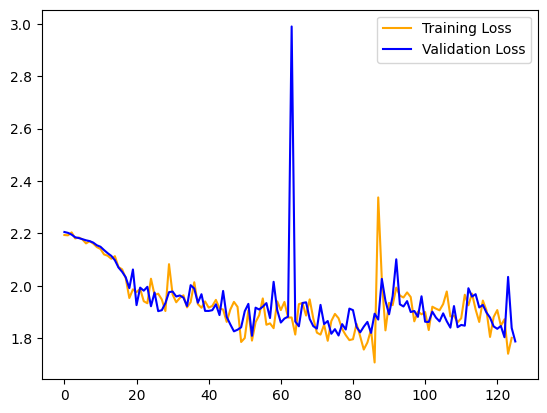

In [ ]:
# Draw training and validation loss plot

plt.plot(city_all_losses[1:], label='Training Loss', color='orange')
plt.plot(city_val_losses, label='Validation Loss', color='blue')
plt.legend()
plt.show()

### **Hyperparameter tuning**

Those results weren't great. Let's try and improve the model by tuning the learning_rate, hidden_size, and n_epochs hyperparameters.

### **2.1:** learning rate tunning

Let's start by tuning the learning_rate and compare the results.

In [ ]:
learning_rates = [0.0002, 0.0015, 0.002, 0.0025, 0.02]
losses = []
accs = []
models = []

for rate in learning_rates:
  model = "./city_RNN" + "_learn_" + str(rate)
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 60,
                              n_epochs = 60000,
                              learning_rate = rate,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = model
                            )
  models.append(model)

  losses.append([city_all_losses, city_val_losses])

  # Load saved model
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=60, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load("./city_RNN" + "_learn_" + str(rate)))

  test_model_multi.eval()
  # Compute Validation accuracy
  val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
  accs.append(val_acc)

print(losses)
print(accs)
print(models)

Epoch 0 (0%)  Loss: 2.2678, Word: dewalgay, Prediction: tensor(0) | incorrect (True:2)
Epoch 5000 (8%)  Loss: 2.1524, Word: rasul chaugai, Prediction: tensor(6) | incorrect (True:7)
Epoch 10000 (16%)  Loss: 2.1324, Word: ummat sifi, Prediction: tensor(3) | correct
Epoch 15000 (25%)  Loss: 2.1038, Word: deh-e bid, Prediction: tensor(6) | correct
Epoch 20000 (33%)  Loss: 2.0231, Word: sizaya, Prediction: tensor(3) | incorrect (True:8)
Epoch 25000 (41%)  Loss: 2.4254, Word: zagalnakchan, Prediction: tensor(0) | incorrect (True:8)
Epoch 30000 (50%)  Loss: 3.2032, Word: debigachha, Prediction: tensor(7) | incorrect (True:2)
Epoch 35000 (58%)  Loss: 2.0189, Word: zar sang-e pa'in, Prediction: tensor(6) | incorrect (True:8)
Epoch 40000 (66%)  Loss: 1.3856, Word: lejing, Prediction: tensor(5) | incorrect (True:1)
Epoch 45000 (75%)  Loss: 2.7738, Word: schaffhausen, Prediction: tensor(1) | incorrect (True:4)
Epoch 50000 (83%)  Loss: 2.7569, Word: jedachil, Prediction: tensor(4) | incorrect (Tru

In [ ]:
test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_multi.load_state_dict(torch.load('./city_RNN_learn_0.0002'))

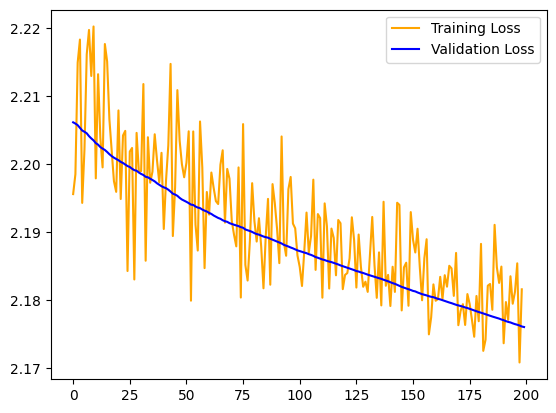

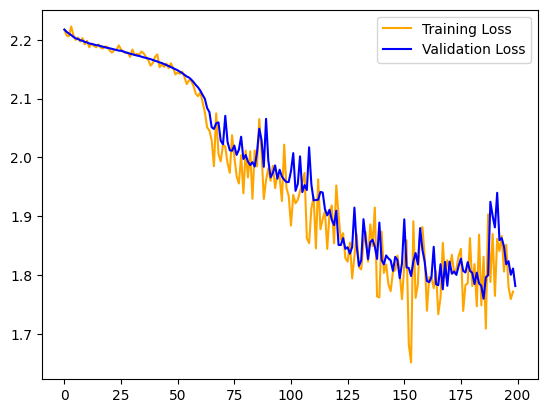

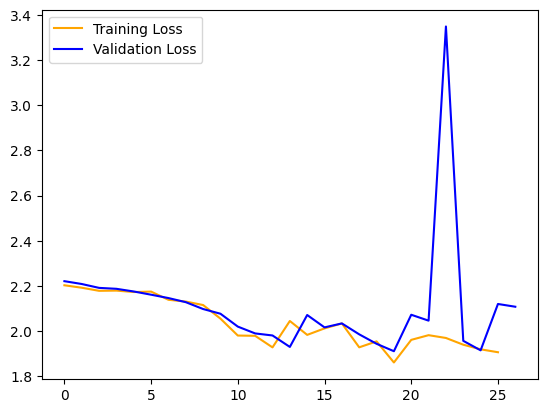

In [ ]:
for i in range(len(losses)):
  plt.plot(losses[i][0][1:], label='Training Loss', color='orange')
  plt.plot(losses[i][1], label='Validation Loss', color='blue')
  plt.legend()
  plt.show()

Looks like the best learning_rate is 0.002.

### **2.2:** hidden layer size tunning

Now let's tune the hidden_size hyperparameter.

In [ ]:
hidden_sizes = [10, 50, 60, 70, 80, 90, 100]
losses2 = []
accs2 = []
models2 = []

for size in hidden_sizes:
  model = "./city_RNN" + "_size_" + str(size)
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = size,
                              n_epochs = 50000,
                              learning_rate = 0.002, ## Best learning rate
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = model
                            )

  models2.append(model)

  losses2.append([city_all_losses, city_val_losses])

  # Load saved model
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=size, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load("./city_RNN" + "_size_" + str(size)))

  test_model_multi.eval()
  # Compute Validation accuracy

  val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
  accs2.append(val_acc)

print(losses2)
print(accs2)
print(models2)

Epoch 0 (0%)  Loss: 2.2671, Word: qolyakhi-ye mabayn, Prediction: tensor(8) | incorrect (True:0)
Epoch 5000 (10%)  Loss: 2.2541, Word: chiuhsinchen, Prediction: tensor(4) | incorrect (True:1)
Epoch 10000 (20%)  Loss: 2.1648, Word: conjat, Prediction: tensor(8) | incorrect (True:4)
Epoch 15000 (30%)  Loss: 1.8778, Word: karim hyder shah, Prediction: tensor(0) | incorrect (True:7)
Epoch 20000 (40%)  Loss: 1.5989, Word: pajjuwala, Prediction: tensor(7) | correct
Epoch 25000 (50%)  Loss: 2.3465, Word: hirnik, Prediction: tensor(5) | incorrect (True:6)
Epoch 30000 (60%)  Loss: 1.8314, Word: ser banda, Prediction: tensor(8) | incorrect (True:7)
Epoch 35000 (70%)  Loss: 1.0515, Word: neyazabad, Prediction: tensor(8) | correct
Epoch 40000 (80%)  Loss: 1.6174, Word: upfkofen, Prediction: tensor(2) | correct
Epoch 45000 (90%)  Loss: 2.1855, Word: deangelis, Prediction: tensor(4) | incorrect (True:2)
Epoch 0 (0%)  Loss: 2.2793, Word: saint-romain-sous-versigny, Prediction: tensor(0) | incorrect (

[0.43666666666666665, 0.4011111111111111, 0.39666666666666667, 0.3877777777777778]


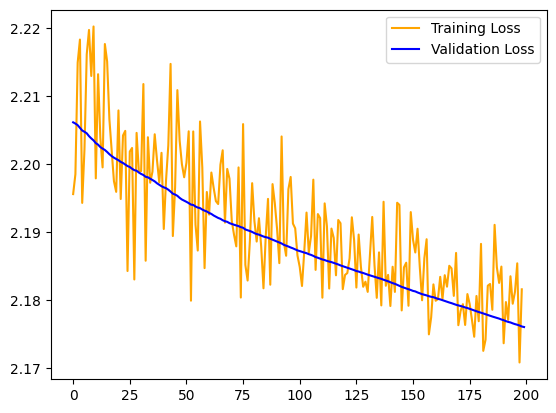

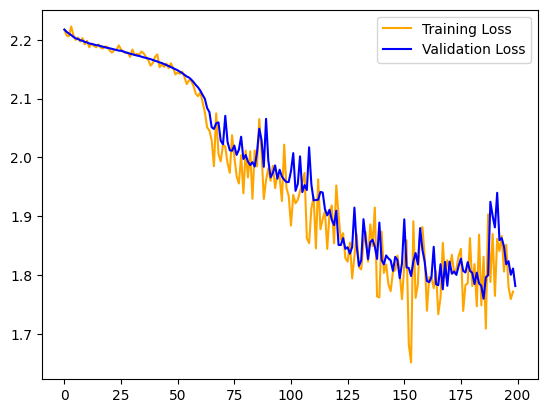

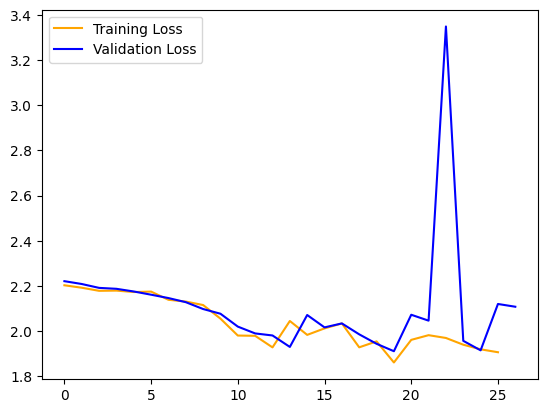

IndexError: ignored

In [ ]:
for i in range(len(losses2)):
  plt.plot(losses[i][0][1:], label='Training Loss', color='orange')
  plt.plot(losses[i][1], label='Validation Loss', color='blue')
  plt.legend()
  plt.show()


Looks like 60 is the best hidden_size value.

### **2.3:** epoch tuning

Now let's tune n_epochs.

In [ ]:
epochs = [1000, 50000, 55000, 60000, 65000, 100000]
losses3 = []
accs3 = []
models3 = []

for epoch in epochs:
  model = "./city_RNN" + "_epoch_" + str(epoch)
  city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 60,
                              n_epochs = epoch,
                              learning_rate = 0.002,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = model
                            )

  models3.append(model)
  losses3.append([city_all_losses, city_val_losses])

  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=60, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load("./city_RNN" + "_epoch_" + str(epoch)))

  test_model_multi.eval()
  val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
  accs3.append(val_acc)


print(models3)
print(losses3)
print(accs3)

Epoch 0 (0%)  Loss: 2.1644, Word: xom bung binh, Prediction: tensor(0) | incorrect (True:5)
Epoch 5000 (9%)  Loss: 2.2225, Word: guangan, Prediction: tensor(0) | incorrect (True:1)
Epoch 10000 (18%)  Loss: 2.1209, Word: sayyid zabar, Prediction: tensor(0) | incorrect (True:8)
Epoch 15000 (27%)  Loss: 1.8900, Word: vuorenkyla, Prediction: tensor(8) | incorrect (True:3)
Epoch 20000 (36%)  Loss: 2.5463, Word: yapai, Prediction: tensor(7) | incorrect (True:1)
Epoch 25000 (45%)  Loss: 1.3370, Word: yurta a. osenina, Prediction: tensor(5) | correct
Epoch 30000 (54%)  Loss: 1.0787, Word: chian, Prediction: tensor(1) | correct
Epoch 35000 (63%)  Loss: 1.0387, Word: cheshizoujia, Prediction: tensor(1) | correct
Epoch 40000 (72%)  Loss: 1.7608, Word: mazra`eh, Prediction: tensor(0) | incorrect (True:6)
Epoch 45000 (81%)  Loss: 1.4936, Word: tall tag, Prediction: tensor(0) | incorrect (True:6)
Epoch 50000 (90%)  Loss: 2.2891, Word: odinski, Prediction: tensor(3) | incorrect (True:5)
Epoch 0 (0%) 

In [ ]:
for model in models3:

  # Load saved model
  test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=60, output_size=len(languages)).to(device)
  test_model_multi.load_state_dict(torch.load(model))

  test_model_multi.eval()
  # Compute Validation accuracy

  val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
  accs3.append(val_acc)

print(accs3)

[0.11222222222222222, 0.42444444444444446, 0.1111111111111111]


In [ ]:
for i in range(len(losses3)):
  print(loss[0])
  plt.plot(losses3[i][0], label='Training Loss', color='orange')
  plt.plot(losses3[i][1], label='Validation Loss', color='blue')
  plt.legend()
  plt.show()


In [ ]:
hidden_sizes = [10, 50, 100]
accs2 = [0.3511111111111111, 0.3977777777777778, 0.39666666666666667]
hidden_sizes = [60, 70, 80, 90]
accs2 = [0.43666666666666665, 0.4011111111111111, 0.39666666666666667, 0.3877777777777778]

[0.43666666666666665, 0.4011111111111111, 0.39666666666666667, 0.3877777777777778]


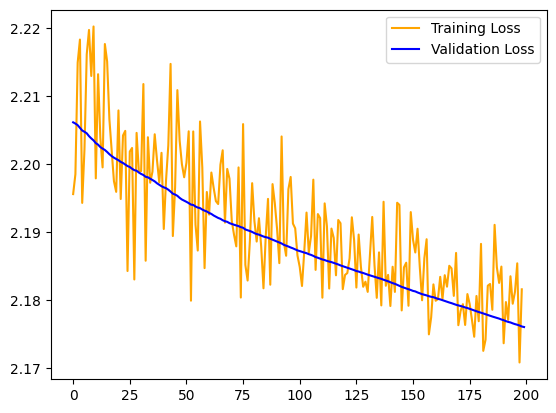

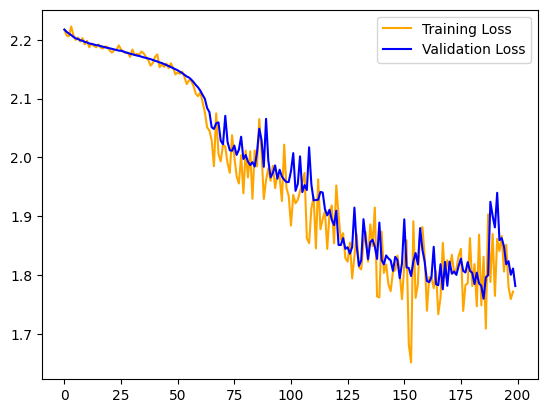

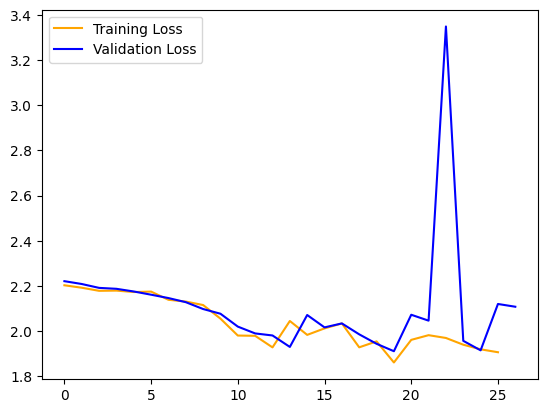

IndexError: ignored

In [ ]:
print(accs2)

for i in range(len(losses2)):
  plt.plot(losses[i][0][1:], label='Training Loss', color='orange')
  plt.plot(losses[i][1], label='Validation Loss', color='blue')
  plt.legend()
  plt.show()


Looks like 60,000 is the best value for n_epochs.